In [1]:
%matplotlib inline
import os
import cv2
import time
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from weapons.CTC_0a import ctc_recog_model

os.environ["CUDA_VISIBLE_DEVICES"] = '0'

def parse_filename(filename):
    """
    vertices: se, sw, nw, ne
    lp_indices: indices in provinces, alphabets, and ads
    area_ratio: in float
    clearliness: in int, the bigger, the more clear.
    """
    name = filename[:filename.index(".")].split('-')
    area_ratio = float('0.'+name[0])
    clearliness = int(name[-1])
    lp_indices = [int(x) for x in name[-3].split('_')]
    vertices = [tuple([int(y) for y in x.split("&")]) for x in name[3].split('_')]
    return vertices, lp_indices, area_ratio, clearliness

def lp_indices2numbers(lp_indices, provinces, alphabets, ads):
    return ''.join([provinces[lp_indices[0]]] + \
                   [alphabets[lp_indices[1]]] + \
                   [ads[x] for x in lp_indices[2:]])

def build_mask(width, length, points, epsilon=1e-8):
    lr, ll, ul, ur = points
    result = np.ones([length, width])
    
    ys = np.array([np.ones(width)*x for x in range(length)])
    xs = np.array([np.arange(width) for _ in range(length)])
    
    if np.abs(lr[0]-ll[0])>epsilon:
        liney1a = (lr[1]-ll[1])/(lr[0]-ll[0])
    else:
        liney1a = (lr[1]-ll[1])/epsilon
    liney1b = lr[1]-liney1a*lr[0]
    if np.abs(ur[0]-ul[0])>epsilon:
        liney2a = (ur[1]-ul[1])/(ur[0]-ul[0])
    else:
        liney2a = (ur[1]-ul[1])/epsilon
    liney2b = ur[1]-liney2a*ur[0]
    mask1 = (ys>(liney2a*xs+liney2b)) * (ys<(liney1a*xs+liney1b))
    
    if np.abs(ul[0]-ll[0])>epsilon:
        linex1a = (ul[1]-ll[1])/(ul[0]-ll[0])
    else:
        linex1a = (ul[1]-ll[1])/epsilon
    linex1b = ul[1]-linex1a*ul[0]
    if np.abs(ur[0]-lr[0])>epsilon:
        linex2a = (ur[1]-lr[1])/(ur[0]-lr[0])
    else:
        linex2a = (ur[1]-lr[1])/epsilon
    linex2b = ur[1]-linex2a*ur[0]
    if np.abs(linex1a)<epsilon: linex1a = epsilon
    if np.abs(linex2a)<epsilon: linex2a = epsilon
    mask2 = (xs>((ys-linex1b)/linex1a)) * (xs<((ys-linex2b)/linex2a))
    
    result*=mask1*mask2
    result = result.astype(np.int32)
    return result

def plot_mask(img, mask):
    plt.figure(figsize=(20,10))
    plt.imshow(img)
    plt.imshow(mask, cmap='gray', alpha=0.7)
    plt.show()

def _upper_lower_bound(img, upper, lower):
    result = (img>upper)*255+(img<upper)*img
    result = (result<lower)*lower+(result>lower)*result
    return result

def random_aug(img, upper_bound = 254, epsilon = 1e-6, verbose = False):
    """
    img as int from 0 to 255
    """
    indicator1 = np.random.random()*3-1
    result = img
    if indicator1>1:
        # 改contrast
        contrast = np.random.random()+0.5
        if verbose: print("contrast:", contrast)
        result = _upper_lower_bound(img*contrast, upper_bound, 0)
    elif indicator1<0:
        # 改brightness
        brightness = np.random.random()*upper_bound*0.6-upper_bound*0.3
        if verbose: print("brightness:", brightness)
        result = _upper_lower_bound(img+brightness, upper_bound, 0)
    result = result/(max(upper_bound, np.max(result))+epsilon)
    
    if np.random.random()>0.5:
        # 变糊
        blurriness = int(np.random.randint(12))*2+3
        if verbose: print("blurriness:", blurriness)
        result = cv2.GaussianBlur(result,(blurriness,blurriness),0)
    return result/max(np.max(result),1.0+epsilon)

def _bound(value, upper, lower):
    return min(max(value, lower), upper)

def crop_out_plate(img, vertices, x_shape = (150,300)):
    pts1 = np.float32(vertices)
    pts2 = np.float32([[x_shape[1],x_shape[0]],[0,x_shape[0]],[0,0],[x_shape[1],0]])
    M=cv2.getPerspectiveTransform(pts1,pts2)
    return cv2.warpPerspective(np.uint8(img),M,(x_shape[1],x_shape[0]))

def path_to_xy_segmentation(path, filename, labels, labels_info, x_shape = (150,300), ext_index = 0.03,
                            verbose = False, augmentation = True):
    img = cv2.imread(path+filename)
    img = np.dot(img,np.array([[0,0,1],[0,1,0],[1,0,0]]))
    
    provinces, alphabets, ads = labels_info
    vertices, lp_indices, area_ratio, clearliness = parse_filename(filename)
    se, sw, nw, ne = vertices
    diagonal_length = ((se[0]-nw[0])**2+(se[1]-nw[1])**2)**0.5
    diagonal_length+= ((ne[0]-sw[0])**2+(ne[1]-sw[1])**2)**0.5
    diagonal_length/= 2
    extension = diagonal_length*0.05
    
    vertices = [(_bound(se[0]+extension, img.shape[0], 0), _bound(se[1]+extension, img.shape[1], 0)),
                (_bound(sw[0]-extension, img.shape[0], 0), _bound(sw[1]+extension, img.shape[1], 0)),
                (_bound(nw[0]-extension, img.shape[0], 0), _bound(nw[1]-extension, img.shape[1], 0)),
                (_bound(ne[0]+extension, img.shape[0], 0), _bound(ne[1]-extension, img.shape[1], 0)),]
    x = crop_out_plate(img, vertices, x_shape = (150,300))
    if augmentation:
        x = random_aug(x, upper_bound = 255)
    else:
        x = x/255.01
    plate = lp_indices2numbers(lp_indices, provinces, alphabets, ads)
    y = np.array([labels[x] for x in plate])
    if verbose: print(plate)
    return x,y

def get_batch(province_dict, labels, labels_info, batch_size, x_shape = (150,300), ext_index = 0.03,
              area_ratio_t = -1, clearliness_t = -1, augmentation = True, verbose = False):
    xs = []
    ys = []
    provinces = list(province_dict.keys())
    while len(ys)<batch_size:
        province = np.random.choice(provinces)
        folder, filename = province_dict[province][np.random.randint(len(province_dict[province]))]
        vertices, lp_indices, area_ratio, clearliness = parse_filename(filename)
        if area_ratio<area_ratio_t or clearliness<clearliness_t: continue
        x,y = path_to_xy_segmentation(folder, filename, labels, labels_info, x_shape, ext_index = ext_index,
                                      verbose = verbose, augmentation = augmentation)
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

def sparse_tuple_from(sequences, dtype=np.int32):
    """
    Create a sparse representention of x.
    Args:
        sequences: a list of lists of type dtype where each element is a sequence
    Returns:
        A tuple with (indices, values, shape)
    """
    indices = []
    values = []

    for n, seq in enumerate(sequences):
        indices.extend(zip([n] * len(seq), range(len(seq))))
        values.extend(seq)

    indices = np.asarray(indices, dtype=np.int64)
    values = np.asarray(values, dtype=dtype)
    shape = np.asarray([len(sequences), np.asarray(indices).max(0)[1] + 1], dtype=np.int64)

    return indices, values, shape

def sparseTuples2dense(sparseTensor):
    pred_dense = -np.ones(sparseTensor[2])
    for i in range(len(sparseTensor[0])):
        pred_dense[sparseTensor[0][i][0],sparseTensor[0][i][1]] = sparseTensor[1][i]
    return pred_dense


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



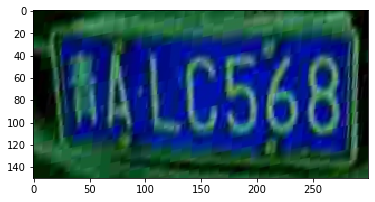

青ALC568
[28 33 43 35 62 63 65]


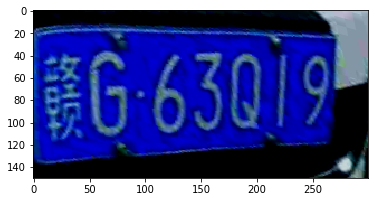

赣G63Q19
[14 39 63 60 47 58 66]
(array([[0, 0],
       [0, 1],
       [0, 2],
       [0, 3],
       [0, 4],
       [0, 5],
       [0, 6],
       [1, 0],
       [1, 1],
       [1, 2],
       [1, 3],
       [1, 4],
       [1, 5],
       [1, 6]]), array([28, 33, 43, 35, 62, 63, 65, 14, 39, 63, 60, 47, 58, 66],
      dtype=int32), array([2, 7]))
[[28 33 43 35 62 63 65]
 [14 39 63 60 47 58 66]]


In [2]:
provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏",
             "浙", "京", "闽", "赣", "鲁","豫", "鄂", "湘", "粤", "桂", "琼","川",
             "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "_"]
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N',
             'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '_']
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P',
       'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3',
       '4', '5', '6', '7', '8', '9', '_']
labels_info = provinces, alphabets, ads
labels_list = []
for item in provinces+ads+alphabets:
    if item != "_" and item not in labels_list:
        labels_list.append(item)
labels_list.append("_")
labels = {}
for i,item in enumerate(labels_list):
    labels[item] = i

file_dict = {}
training_dict = {}
test_dict = {}
# folders = ["CCPD2019/ccpd_base/", "CCPD2019/ccpd_blur/", "CCPD2019/ccpd_challenge/",
#            "CCPD2019/ccpd_db/", "CCPD2019/ccpd_fn/",
#            "CCPD2019/ccpd_rotate/", "CCPD2019/ccpd_tilt/", "CCPD2019/ccpd_weather/"]
# folders = ["CCPD2019/ccpd_base/"]
folders = ["CCPD2019/ccpd_base/", "CCPD2019/ccpd_rotate/", "CCPD2019/ccpd_tilt/", "CCPD2019/ccpd_weather/"]
for folder in folders:
    file_dict[folder] = [x for x in os.listdir(folder) if x[0]!='.']
    split_point = int(len(file_dict[folder])/20)
    training_dict[folder] = file_dict[folder][:-split_point]
    test_dict[folder] = file_dict[folder][-split_point:]

province_dict_train = {}
province_dict_test = {}

for folder in folders:
    for filename in training_dict[folder]:
        vertices, lp_indices, area_ratio, clearliness = parse_filename(filename)
        plate = lp_indices2numbers(lp_indices, provinces, alphabets, ads)
        if plate[0] in province_dict_train:
            province_dict_train[plate[0]].append((folder, filename))
        else:
            province_dict_train[plate[0]] = [(folder, filename),]
for folder in folders:
    for filename in test_dict[folder]:
        vertices, lp_indices, area_ratio, clearliness = parse_filename(filename)
        plate = lp_indices2numbers(lp_indices, provinces, alphabets, ads)
        if plate[0] in province_dict_test:
            province_dict_test[plate[0]].append((folder, filename))
        else:
            province_dict_test[plate[0]] = [(folder, filename),]

batch_size = 2
xs, ys = get_batch(province_dict_train, labels, labels_info, batch_size)
for i in range(batch_size):
    plt.imshow(xs[i])
    plt.show()
    print(''.join([labels_list[x] for x in ys[i]]))
    print(ys[i])
print(sparse_tuple_from(ys))
print(sparseTuples2dense(sparse_tuple_from(ys)).astype(int))

In [3]:
print(np.transpose(xs, axes = [0,2,1,3]).shape)

(2, 300, 150, 3)


In [15]:
print(len(labels_list)+2)

70


In [24]:
BATCH_SIZE = 512
n_batch = 200
# 初始 learning rate 应当设在 1e-3 左右
learning_rate = 5e-5
saving_period = 50
model_name = "C_0a_1"
if model_name not in os.listdir('models/'):
    os.mkdir('models/'+model_name)
x_shape = (150,300)

total_time = []

tf.reset_default_graph()
model = ctc_recog_model(len(labels_list)+2)

gpu_options = tf.GPUOptions(allow_growth=True)
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options,
                                      allow_soft_placement=True,
                                      log_device_placement=False)) as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    saver.restore(sess, "models/C_0a_1/C_0a_1_0.ckpt")
    # tensorboard --logdir logs/
    # summary_writer = tf.summary.FileWriter(logdir = "logs", graph = tf.get_default_graph())
    xs, ys = get_batch(province_dict_train, labels, labels_info, BATCH_SIZE, x_shape = x_shape)
    prediction = model.predict(sess, np.transpose(xs, axes = [0,2,1,3]),)
    prediction = sparseTuples2dense(prediction[0]).astype(int)
    for j in range(min(5, BATCH_SIZE)):
        print(ys[j])
        print(prediction[j][:10])

    for i in range(1, 1+n_batch):
        start_time = time.time()
        xs, ys = get_batch(province_dict_train, labels, labels_info, BATCH_SIZE, x_shape = x_shape)
        loss, summary = model.train(sess, learning_rate,
                                    np.transpose(xs, axes = [0,2,1,3]),
                                    sparse_tuple_from(ys))
        # summary_writer.add_summary(summary, i)
        if i%10 == 0:
            print(i, loss)
        
        if i%saving_period == 0:
            save_path = saver.save(sess, "models/"+model_name+"/"+model_name+"_"+str(int(i/10000))+".ckpt")
            print("Model saved in path: "+save_path)
            xs, ys = get_batch(province_dict_train, labels, labels_info, BATCH_SIZE, x_shape = x_shape)
            prediction = model.predict(sess, np.transpose(xs, axes = [0,2,1,3]),)
            prediction = sparseTuples2dense(prediction[0]).astype(int)
            for j in range(min(5, BATCH_SIZE)):
                print(ys[j])
                print(prediction[j][:10])
        
        end_time = time.time()
        if i>2:
            total_time.append(end_time-start_time)
            total_time = total_time[-saving_period:]
        if i%saving_period == 0:
            n = np.round(3600/np.mean(total_time), 2)
            print("每小时可计算",n,"batches")

INFO:tensorflow:Restoring parameters from models/C_0a_1/C_0a_1_0.ckpt
[ 0 33 63 58 43 60 65]
[ 0 33 63 58 43 60 65]
[ 9 33 38 36 58 64 62]
[ 9 33 38 36 58 64 62]
[19 33 35 59 65 36 65]
[19 33 35 59 65 36 65]
[11 39 53 41 59 65 58]
[11 39 53 41 59 65 58]
[18 33 58 34 65 62 38]
[18 33 58 34 65 62 38]
10 0.11467625
20 0.17372441
30 0.12645891
40 0.16280058
50 0.10456794
Model saved in path: models/C_0a_1/C_0a_1_0.ckpt
[ 4 34 57 64 60 50 59]
[ 4 34 57 64 60 50 59]
[24 33 62 65 64 33 49]
[24 33 62 65 64 33 49]
[24 33 63 60 60 52 47]
[24 33 63 60 60 52 47]
[29 33 49 37 58 57 63]
[29 33 49 37 58 57 63]
[23 36 33 54 59 62 65]
[23 36 33 54 59 62 65]
每小时可计算 169.13 batches
60 0.16535585
70 0.13339087
80 0.069359414
90 0.13355745
100 0.116742775
Model saved in path: models/C_0a_1/C_0a_1_0.ckpt
[25 33 34 47 62 63 66]
[25 33 34 47 62 63 66]
[26 36 56 43 60 62 64]
[26 36 56 43 60 62 64]
[16 49 56 34 65 64 57]
[16 49 56 34 65 64 57]
[29 33 49 37 58 57 63]
[29 33 49 37 58 57 63]
[30 42 33 57 59 62 58]


In [26]:
BATCH_SIZE = 512
n_test_batch = 20
model_name = "C_0a_1"
x_shape = (150,300)

tf.reset_default_graph()
model = ctc_recog_model(len(labels_list)+2)

gpu_options = tf.GPUOptions(allow_growth=True)
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options,
                                      allow_soft_placement=True,
                                      log_device_placement=False)) as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    saver.restore(sess, "models/C_0a_1/C_0a_1_0.ckpt")
    n_correct = 0
    for i_test_batch in range(n_test_batch):
        xs, ys = get_batch(province_dict_train, labels, labels_info, BATCH_SIZE, x_shape = x_shape,
                           area_ratio_t = 0.03, clearliness_t = 90, augmentation = False)
        prediction = model.predict(sess, np.transpose(xs, axes = [0,2,1,3]),)
        prediction = sparseTuples2dense(prediction[0]).astype(int)
        for j in range(BATCH_SIZE):
            ground_truth = list(ys[j])
            pred = [x for x in prediction[j][:10] if x>=0]
            if ground_truth == pred: n_correct+=1
        print("正确率 =",np.round(100*n_correct/((i_test_batch+1)*BATCH_SIZE), 2),
              "%, 正确数 =",n_correct,'/',(i_test_batch+1)*BATCH_SIZE)
    print("=========================================================")
    print("正确率 =",np.round(100*n_correct/(BATCH_SIZE*n_test_batch), 2),
          "%, 正确数 =",n_correct,'/',n_test_batch*BATCH_SIZE)

INFO:tensorflow:Restoring parameters from models/C_0a_1/C_0a_1_0.ckpt
正确率 = 98.83 %, 正确数 = 506 / 512
正确率 = 98.93 %, 正确数 = 1013 / 1024
正确率 = 98.89 %, 正确数 = 1519 / 1536
正确率 = 99.02 %, 正确数 = 2028 / 2048
正确率 = 98.95 %, 正确数 = 2533 / 2560
正确率 = 98.96 %, 正确数 = 3040 / 3072
正确率 = 98.91 %, 正确数 = 3545 / 3584
正确率 = 98.93 %, 正确数 = 4052 / 4096
正确率 = 98.91 %, 正确数 = 4558 / 4608
正确率 = 98.96 %, 正确数 = 5067 / 5120
正确率 = 99.01 %, 正确数 = 5576 / 5632
正确率 = 98.94 %, 正确数 = 6079 / 6144
正确率 = 98.92 %, 正确数 = 6584 / 6656
正确率 = 98.9 %, 正确数 = 7089 / 7168
正确率 = 98.87 %, 正确数 = 7593 / 7680
正确率 = 98.89 %, 正确数 = 8101 / 8192
正确率 = 98.86 %, 正确数 = 8605 / 8704
正确率 = 98.86 %, 正确数 = 9111 / 9216
正确率 = 98.88 %, 正确数 = 9619 / 9728
正确率 = 98.92 %, 正确数 = 10129 / 10240
正确率 = 98.92 %, 正确数 = 10129 / 10240
